In [2]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE



In [3]:
images = []
labels = []
for subfolder in tqdm(os.listdir('Alzheimer_s Dataset')):
    subfolder_path = os.path.join('Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 55.19it/s]


,image,label
0,Alzheimer_s Dataset\test\MildDemented\26 (19).jpg,MildDemented
1,Alzheimer_s Dataset\test\MildDemented\26 (20).jpg,MildDemented
2,Alzheimer_s Dataset\test\MildDemented\26 (21).jpg,MildDemented
3,Alzheimer_s Dataset\test\MildDemented\26 (22).jpg,MildDemented
4,Alzheimer_s Dataset\test\MildDemented\26 (23).jpg,MildDemented
...,...,...
6395,Alzheimer_s Dataset\train\VeryMildDemented\ver...,VeryMildDemented
6396,Alzheimer_s Dataset\train\VeryMildDemented\ver...,VeryMildDemented
6397,Alzheimer_s Dataset\train\VeryMildDemented\ver...,VeryMildDemented
6398,Alzheimer_s Dataset\train\VeryMildDemented\ver...,VeryMildDemented


In [6]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

for i in range(len(train_data_gen)):
    train_data, train_labels = train_data_gen[i]

Found 6400 validated image filenames belonging to 4 classes.


In [7]:
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

In [8]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

C:\Users\ppk61\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ppk61\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ppk61\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ppk61\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ppk61\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
  

(12800, 176, 176, 3) (12800, 4)


In [9]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]

In [10]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


In [11]:
def create_cnn_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3,3), strides=2, padding='same', activation='relu', input_shape=(176,176,3)),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        keras.layers.Conv2D(64, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        keras.layers.Conv2D(128, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(4, activation='softmax')
    ])
    return model

In [12]:
# Instantiate multiple instances of the CNN model
num_models = 4
cnn_models = [create_cnn_model() for _ in range(num_models)]

checkpoint_cb = checkpoint_cb = ModelCheckpoint("model_{epoch:02d}.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

C:\Users\ppk61\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Train each CNN model and save them
for i, model in enumerate(cnn_models):
    print(f"Training and saving CNN Model {i+1}/{num_models}")
    # Train the model...
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    hist = model.fit(X_train,y_train, epochs=30, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])
    # Save the model
    model.save(f"model_{i+1}.h5")

Training and saving CNN Model 1/4
Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.4665 - loss: 1.0841 - val_accuracy: 0.7271 - val_loss: 0.6142
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7710 - loss: 0.5069 - val_accuracy: 0.8661 - val_loss: 0.3204
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8817 - loss: 0.2665 - val_accuracy: 0.8990 - val_loss: 0.2625
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9264 - loss: 0.1751 - val_accuracy: 0.9396 - val_loss: 0.1581
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9693 - loss: 0.0874 - val_accuracy: 0.9573 - val_loss: 0.1172
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9757 - loss: 0.0645 - val_accuracy: 0.9661 - val_loss: 0.0891
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9826 - loss: 0.0466 - val_accuracy: 0.9578 - val_loss: 0.1215
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - 

Training and saving CNN Model 2/4
Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.4461 - loss: 1.1075 - val_accuracy: 0.7448 - val_loss: 0.5646
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8102 - loss: 0.4300 - val_accuracy: 0.8776 - val_loss: 0.2696
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9111 - loss: 0.2233 - val_accuracy: 0.9250 - val_loss: 0.1744
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9477 - loss: 0.1335 - val_accuracy: 0.9266 - val_loss: 0.1813
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9721 - loss: 0.0719 - val_accuracy: 0.9573 - val_loss: 0.1154
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9802 - loss: 0.0490 - val_accuracy: 0.9615 - val_loss: 0.0985
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9892 - loss: 0.0309 - val_accuracy: 0.9708 - val_loss: 0.0857
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - 

Training and saving CNN Model 3/4
Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4118 - loss: 1.1623 - val_accuracy: 0.6807 - val_loss: 0.6683
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7493 - loss: 0.5435 - val_accuracy: 0.8167 - val_loss: 0.4168
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8572 - loss: 0.3280 - val_accuracy: 0.8964 - val_loss: 0.2311
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9161 - loss: 0.2000 - val_accuracy: 0.9245 - val_loss: 0.1940
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9561 - loss: 0.1159 - val_accuracy: 0.9510 - val_loss: 0.1340
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9644 - loss: 0.0916 - val_accuracy: 0.9479 - val_loss: 0.1522
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9741 - loss: 0.0673 - val_accuracy: 0.9688 - val_loss: 0.0941
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - 

Training and saving CNN Model 4/4
Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.4687 - loss: 1.0824 - val_accuracy: 0.7505 - val_loss: 0.5457
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7832 - loss: 0.4732 - val_accuracy: 0.7859 - val_loss: 0.5002
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8836 - loss: 0.2665 - val_accuracy: 0.8979 - val_loss: 0.2389
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9448 - loss: 0.1430 - val_accuracy: 0.9458 - val_loss: 0.1353
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9695 - loss: 0.0811 - val_accuracy: 0.9479 - val_loss: 0.1357
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9764 - loss: 0.0592 - val_accuracy: 0.9714 - val_loss: 0.0761
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9895 - loss: 0.0298 - val_accuracy: 0.9531 - val_loss: 0.1365
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - 

In [14]:
hist_=pd.DataFrame(hist.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.601004,0.836538,0.750521,0.545681
1,0.818973,0.411353,0.785937,0.500194
2,0.902679,0.227643,0.897917,0.238859
3,0.946987,0.136658,0.945833,0.135330
4,0.971094,0.078883,0.947917,0.135703
5,0.976786,0.060594,0.971354,0.076075
6,0.980246,0.063975,0.953125,0.136508
7,0.986272,0.038535,0.976042,0.067831
8,0.992857,0.021376,0.961458,0.131985
9,0.991406,0.027986,0.973437,0.065819


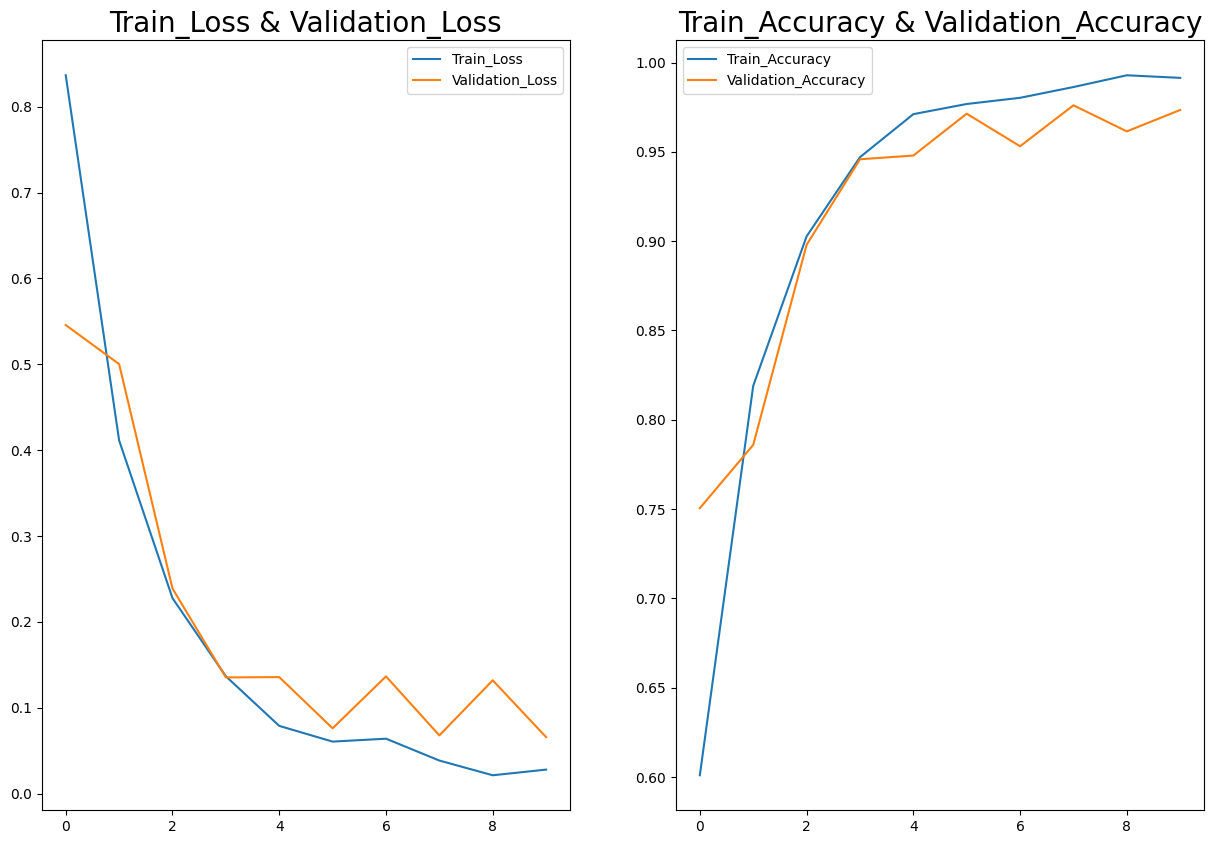

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [16]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7346 - loss: 0.5492
Test Loss = 0.550681471824646
Test Accuracy = 0.7369791865348816


In [17]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


,Actual,Prediction
0,1,1
1,1,1
2,0,3
3,2,2
4,2,2
...,...,...
1915,2,2
1916,0,3
1917,2,2
1918,3,3


array([[310,   0,  13, 157],
       [  0, 480,   0,   0],
       [ 25,   1, 346, 108],
       [ 32,   0, 169, 279]], dtype=int64)

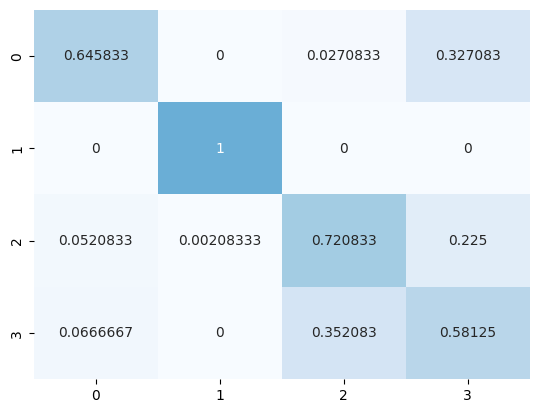

In [18]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [19]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.84      0.65      0.73       480
           1       1.00      1.00      1.00       480
           2       0.66      0.72      0.69       480
           3       0.51      0.58      0.54       480

    accuracy                           0.74      1920
   macro avg       0.75      0.74      0.74      1920
weighted avg       0.75      0.74      0.74      1920



In [34]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define function to prepare image
def prepare_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)  # Load the image
    img_array = img_to_array(img)  # Convert the image to numpy array
    img_array = img_array / 255.0  # Scale the image (if your model requires normalization)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Load saved models
models = []
for i in range(1, 5):
    model_path = f"model_{i}.h5"
    model = keras.models.load_model(model_path)
    models.append(model)

# Define image path
image_path = "C:\\Users\\ppk61\\Downloads\\finalyearproject\\TK164571--DETECTION OF ALZHEIMERS DISEASE USING MODIFIED CNN COMPRED WITH DEEP LEARNING MODELS\\CODE\\BACKEND\\test\\NonDemented\\29 (100).jpg"

# Prepare the image
prepared_image = prepare_image(image_path, target_size=(176, 176))

# Predict using each model
predictions = [model.predict(prepared_image) for model in models]

# Combine predictions
ensemble_prediction = np.mean(predictions, axis=0)
predicted_class = np.argmax(ensemble_prediction, axis=1)  # Get the class with highest probability

# Output the result
class_labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
predicted_class_label = class_labels[predicted_class[0]]
print(f"Predicted Class: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted Class: NonDemented


In [55]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the function to create a MobileNet model
def create_mobilenet_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(176, 176, 3))
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom layers on top of MobileNet
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(4, activation='softmax')
    ])
    
    return model

# Instantiate multiple instances of the MobileNet model
num_models = 4
mobilenet_models = [create_mobilenet_model() for _ in range(num_models)]

checkpoint_cb = ModelCheckpoint("model_mobilenet{epoch:02d}.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Train each MobileNet model and save them
for i, model in enumerate(mobilenet_models):
    print(f"Training and saving MobileNet Model {i+1}/{num_models}")
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Train the model
    hist = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])
    # Save the model
    model.save(f"mobilenet_model_{i+1}.h5")


C:\Users\ppk61\AppData\Local\Temp\ipykernel_30216\226473384.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(176, 176, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training and saving MobileNet Model 1/4
Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 68s 231ms/step - accuracy: 0.5604 - loss: 1.2281 - val_accuracy: 0.7344 - val_loss: 0.6037
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 65s 231ms/step - accuracy: 0.7324 - loss: 0.5998 - val_accuracy: 0.6969 - val_loss: 0.6192
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 63s 225ms/step - accuracy: 0.7602 - loss: 0.5306 - val_accuracy: 0.7786 - val_loss: 0.5075
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 62s 222ms/step - accuracy: 0.8116 - loss: 0.4417 - val_accuracy: 0.7661 - val_loss: 0.5296
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 65s 231ms/step - accuracy: 0.8236 - loss: 0.4203 - val_accuracy: 0.8203 - val_loss: 0.4024
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 64s 230ms/step - accuracy: 0.8447 - loss: 0.3768 - val_accuracy: 0.8620 - val_loss: 0.3503
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 62s 220ms/step - accuracy: 0.8651 - loss: 0.3256 - val_accuracy: 0.8089 - val_loss:

Training and saving MobileNet Model 2/4
Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 66s 224ms/step - accuracy: 0.5566 - loss: 1.1992 - val_accuracy: 0.7354 - val_loss: 0.5898
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 61s 216ms/step - accuracy: 0.7494 - loss: 0.5695 - val_accuracy: 0.7391 - val_loss: 0.5470
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 61s 217ms/step - accuracy: 0.7751 - loss: 0.5176 - val_accuracy: 0.7521 - val_loss: 0.5278
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 60s 215ms/step - accuracy: 0.8014 - loss: 0.4574 - val_accuracy: 0.8042 - val_loss: 0.4554
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 61s 216ms/step - accuracy: 0.8268 - loss: 0.3981 - val_accuracy: 0.8411 - val_loss: 0.3898
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 61s 218ms/step - accuracy: 0.8536 - loss: 0.3566 - val_accuracy: 0.8552 - val_loss: 0.3623
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 61s 217ms/step - accuracy: 0.8463 - loss: 0.3661 - val_accuracy: 0.7672 - val_loss: 0.5362
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 63s

Training and saving MobileNet Model 3/4
Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 63s 218ms/step - accuracy: 0.5475 - loss: 1.3380 - val_accuracy: 0.6276 - val_loss: 0.7382
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 60s 215ms/step - accuracy: 0.7311 - loss: 0.5953 - val_accuracy: 0.7802 - val_loss: 0.4995
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 62s 221ms/step - accuracy: 0.7897 - loss: 0.4915 - val_accuracy: 0.7932 - val_loss: 0.4638
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 62s 221ms/step - accuracy: 0.8051 - loss: 0.4463 - val_accuracy: 0.8031 - val_loss: 0.4490
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 62s 221ms/step - accuracy: 0.8259 - loss: 0.4050 - val_accuracy: 0.7781 - val_loss: 0.4987
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 62s 221ms/step - accuracy: 0.8312 - loss: 0.3926 - val_accuracy: 0.8344 - val_loss: 0.3821
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 61s 218ms/step - accuracy: 0.8633 - loss: 0.3253 - val_accuracy: 0.8370 - val_loss: 0.3628
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 60s

Training and saving MobileNet Model 4/4
Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 63s 217ms/step - accuracy: 0.5474 - loss: 1.2578 - val_accuracy: 0.7276 - val_loss: 0.5977
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 60s 216ms/step - accuracy: 0.7426 - loss: 0.5817 - val_accuracy: 0.7839 - val_loss: 0.4937
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 61s 218ms/step - accuracy: 0.7669 - loss: 0.5238 - val_accuracy: 0.8042 - val_loss: 0.4525
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 63s 225ms/step - accuracy: 0.8055 - loss: 0.4520 - val_accuracy: 0.8286 - val_loss: 0.4171
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 61s 217ms/step - accuracy: 0.8352 - loss: 0.3911 - val_accuracy: 0.8182 - val_loss: 0.4160
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 60s 216ms/step - accuracy: 0.8387 - loss: 0.3888 - val_accuracy: 0.8229 - val_loss: 0.4168
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 61s 218ms/step - accuracy: 0.8583 - loss: 0.3383 - val_accuracy: 0.8516 - val_loss: 0.3652
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 61s

In [57]:
hist_=pd.DataFrame(hist.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.637612,0.861030,0.727604,0.597742
1,0.753683,0.561161,0.783854,0.493698
2,0.782701,0.497985,0.804167,0.452466
3,0.807031,0.448121,0.828646,0.417059
4,0.831362,0.399616,0.818229,0.416018
5,0.838839,0.380429,0.822917,0.416847
6,0.861496,0.332750,0.851562,0.365168
7,0.870871,0.315080,0.866667,0.312463
8,0.886272,0.280970,0.884896,0.287829
9,0.895201,0.258080,0.885417,0.286777


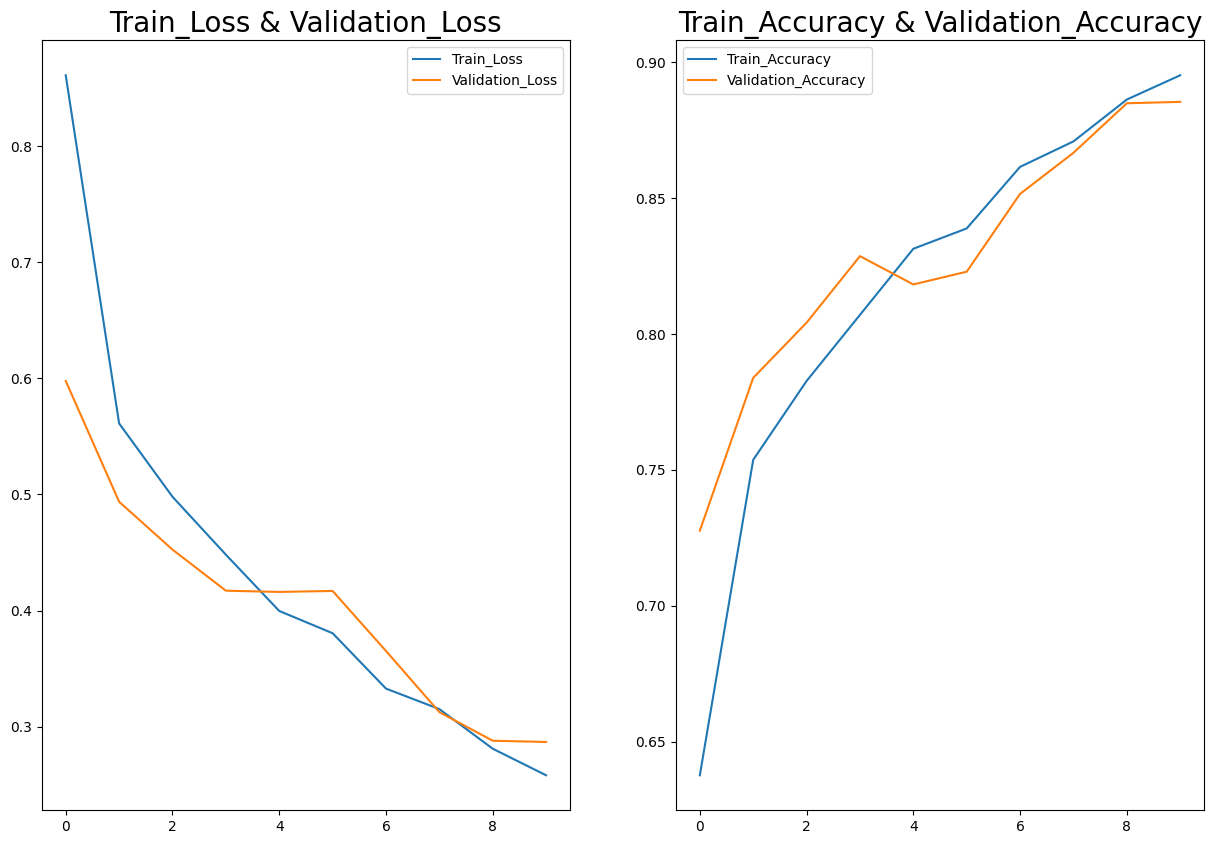

In [59]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [61]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.7566 - loss: 0.5760
Test Loss = 0.5873411893844604
Test Accuracy = 0.7442708611488342


In [63]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step


,Actual,Prediction
0,1,1
1,1,1
2,0,0
3,2,2
4,2,2
...,...,...
1915,2,2
1916,0,0
1917,2,2
1918,3,3


array([[306,   0,   6, 168],
       [  0, 480,   0,   0],
       [ 19,   0, 272, 189],
       [ 40,   0,  69, 371]], dtype=int64)

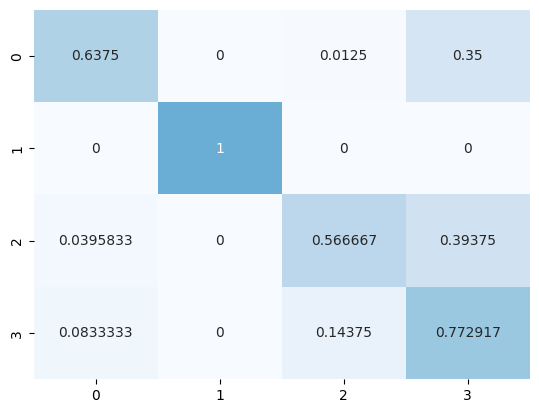

In [65]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [67]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.84      0.64      0.72       480
           1       1.00      1.00      1.00       480
           2       0.78      0.57      0.66       480
           3       0.51      0.77      0.61       480

    accuracy                           0.74      1920
   macro avg       0.78      0.74      0.75      1920
weighted avg       0.78      0.74      0.75      1920



In [75]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121  # Import DenseNet model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the function to create a DenseNet model
def create_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(176, 176, 3))
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom layers on top of DenseNet
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(4, activation='softmax')
    ])
    
    return model

# Instantiate multiple instances of the DenseNet model
num_models = 4
densenet_models = [create_densenet_model() for _ in range(num_models)]

checkpoint_cb = ModelCheckpoint("model_densenet{epoch:02d}.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Train each DenseNet model and save them
for i, model in enumerate(densenet_models):
    print(f"Training and saving DenseNet Model {i+1}/{num_models}")
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Train the model
    hist = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])
    # Save the model
    model.save(f"densenet_model_{i+1}.h5")


Training and saving DenseNet Model 1/4
Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 255s 870ms/step - accuracy: 0.4715 - loss: 1.5514 - val_accuracy: 0.6464 - val_loss: 0.7996
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 221s 790ms/step - accuracy: 0.6662 - loss: 0.7483 - val_accuracy: 0.7141 - val_loss: 0.6336
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 225s 805ms/step - accuracy: 0.7096 - loss: 0.6502 - val_accuracy: 0.7203 - val_loss: 0.5974
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 227s 811ms/step - accuracy: 0.7280 - loss: 0.6109 - val_accuracy: 0.7240 - val_loss: 0.5887
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 227s 809ms/step - accuracy: 0.7311 - loss: 0.6058 - val_accuracy: 0.7036 - val_loss: 0.6148
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 225s 804ms/step - accuracy: 0.7610 - loss: 0.5502 - val_accuracy: 0.7490 - val_loss: 0.5540
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 218s 779ms/step - accuracy: 0.7670 - loss: 0.5325 - val_accuracy: 0.7703 - val_loss: 0.5125
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━

Training and saving DenseNet Model 2/4
Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 231s 788ms/step - accuracy: 0.4692 - loss: 1.5254 - val_accuracy: 0.6948 - val_loss: 0.7146
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 215s 769ms/step - accuracy: 0.6905 - loss: 0.7166 - val_accuracy: 0.6927 - val_loss: 0.7149
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 214s 766ms/step - accuracy: 0.7021 - loss: 0.6550 - val_accuracy: 0.7234 - val_loss: 0.6476
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 211s 755ms/step - accuracy: 0.7327 - loss: 0.6048 - val_accuracy: 0.7125 - val_loss: 0.6164
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 211s 754ms/step - accuracy: 0.7380 - loss: 0.5804 - val_accuracy: 0.7505 - val_loss: 0.5534
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 210s 752ms/step - accuracy: 0.7572 - loss: 0.5481 - val_accuracy: 0.6458 - val_loss: 0.7770
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 212s 759ms/step - accuracy: 0.7594 - loss: 0.5459 - val_accuracy: 0.7266 - val_loss: 0.5703
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━

Training and saving DenseNet Model 3/4
Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 227s 777ms/step - accuracy: 0.4748 - loss: 1.4938 - val_accuracy: 0.6427 - val_loss: 0.7768
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 215s 768ms/step - accuracy: 0.6768 - loss: 0.7269 - val_accuracy: 0.7026 - val_loss: 0.6527
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 210s 751ms/step - accuracy: 0.7102 - loss: 0.6458 - val_accuracy: 0.6932 - val_loss: 0.6443
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 205s 734ms/step - accuracy: 0.7321 - loss: 0.6092 - val_accuracy: 0.7469 - val_loss: 0.5624
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 204s 730ms/step - accuracy: 0.7415 - loss: 0.5804 - val_accuracy: 0.7396 - val_loss: 0.5864
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 203s 725ms/step - accuracy: 0.7454 - loss: 0.5711 - val_accuracy: 0.7432 - val_loss: 0.5592
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 206s 737ms/step - accuracy: 0.7749 - loss: 0.5120 - val_accuracy: 0.7594 - val_loss: 0.5334
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━

Training and saving DenseNet Model 4/4
Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 248s 825ms/step - accuracy: 0.4644 - loss: 1.6090 - val_accuracy: 0.6740 - val_loss: 0.7219
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 222s 794ms/step - accuracy: 0.6674 - loss: 0.7315 - val_accuracy: 0.6604 - val_loss: 0.6861
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 223s 796ms/step - accuracy: 0.7036 - loss: 0.6559 - val_accuracy: 0.7234 - val_loss: 0.6248
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 221s 789ms/step - accuracy: 0.7441 - loss: 0.5912 - val_accuracy: 0.7521 - val_loss: 0.5727
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 209s 747ms/step - accuracy: 0.7521 - loss: 0.5685 - val_accuracy: 0.7609 - val_loss: 0.5529
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 209s 748ms/step - accuracy: 0.7539 - loss: 0.5619 - val_accuracy: 0.7516 - val_loss: 0.5550
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 212s 758ms/step - accuracy: 0.7653 - loss: 0.5421 - val_accuracy: 0.7474 - val_loss: 0.5576
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━

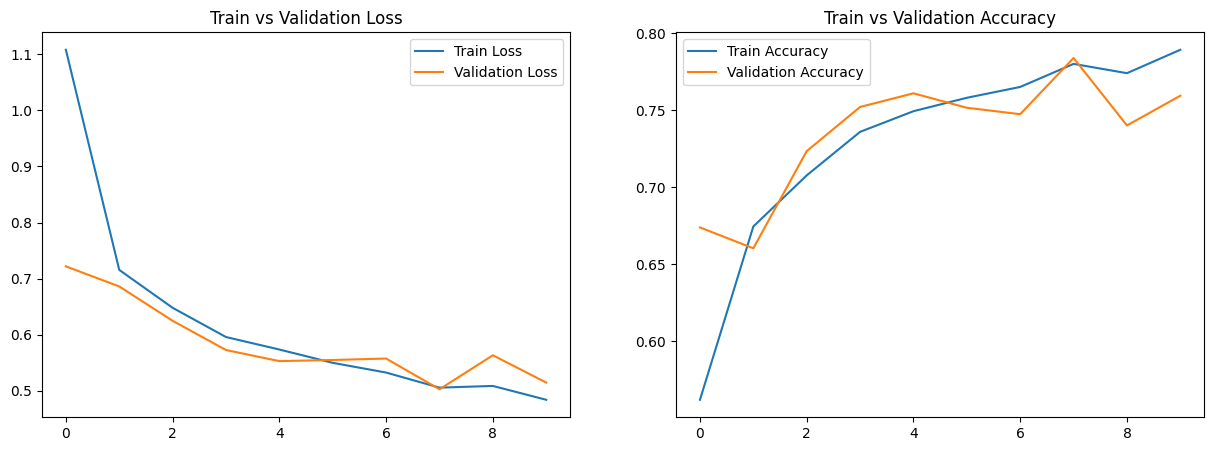

60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 668ms/step - accuracy: 0.6839 - loss: 0.7040
Test Loss = 0.7144997119903564
Test Accuracy = 0.6760416626930237
60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 682ms/step


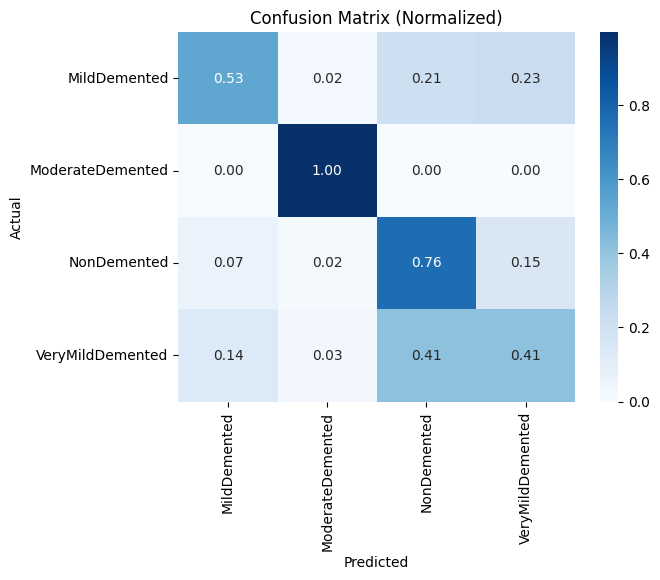

Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.72      0.53      0.61       480
ModerateDemented       0.93      1.00      0.96       480
     NonDemented       0.55      0.76      0.64       480
VeryMildDemented       0.52      0.41      0.46       480

        accuracy                           0.68      1920
       macro avg       0.68      0.68      0.67      1920
    weighted avg       0.68      0.68      0.67      1920



In [77]:
hist_ = pd.DataFrame(model.history.history) if hasattr(model, 'history') else None

if hist_ is not None:
  
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist_['loss'], label='Train Loss')
    plt.plot(hist_['val_loss'], label='Validation Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist_['accuracy'], label='Train Accuracy')
    plt.plot(hist_['val_accuracy'], label='Validation Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.show()


score, acc = model.evaluate(X_test, y_test)
print("Test Loss =", score)
print("Test Accuracy =", acc)


predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)


CM = confusion_matrix(y_true, y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

In [114]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

models_list = []

for i in range(1, 4):
    filename = f"model_{i}.h5"
    if os.path.exists(filename):
        models_list.append(load_model(filename))
    else:
        print(f"Warning: {filename} not found.")


for i in range(1, 4):
    filename = f"mobilenet_model_{i}.h5"
    if os.path.exists(filename):
        models_list.append(load_model(filename))
    else:
        print(f"Warning: {filename} not found.")

# Load 30 DenseNet models
for i in range(1, 4):
    filename = f"densenet_model_{i}.h5"
    if os.path.exists(filename):
        models_list.append(load_model(filename))
    else:
        print(f"Warning: {filename} not found.")

# Get predictions from all models
all_preds = [model.predict(X_test) for model in models_list]

# Average predictions
ensemble_preds_prob = np.mean(all_preds, axis=0)

# Final prediction
ensemble_preds = np.argmax(ensemble_preds_prob, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(true_labels, ensemble_preds))
print("\nClassification Report:\n", classification_report(true_labels, ensemble_preds))


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 644ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 629ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 614ms/step
Confusion Matrix:
 [[476   0   2   2]
 [  0 480   0   0]
 [  5   0 451  24]
 [ 15   0  50 415]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       480
           1       1.00      1.00      1.00       480
           2       0.90      0.94      0.92       480
           3       0.94      0.86      0.90       480

    accuracy                           0.95      1920
   macro avg       0.95      0.95      0.95      1920
weighted avg       0.95      0.95      0.95      1920



In [183]:
from tensorflow.keras.preprocessing import image

# Load and preprocess one image
img_path = "C:\\Users\\ppk61\\Downloads\\c0068120-800px-wm.jpg" # 🔁 Replace with your actual image path
img = image.load_img(img_path, target_size=(176, 176))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 176, 176, 3)
img_array = img_array / 255.0  # Normalize (assuming all models used this)
models_list = []

for i in range(1, 4):
    filename = f"model_{i}.h5"
    if os.path.exists(filename):
        models_list.append(load_model(filename))

for i in range(1, 4):
    filename = f"mobilenet_model_{i}.h5"
    if os.path.exists(filename):
        models_list.append(load_model(filename))

for i in range(1, 4):
    filename = f"densenet_model_{i}.h5"
    if os.path.exists(filename):
        models_list.append(load_model(filename))
# Predict on the single image from each model
all_preds = [model.predict(img_array) for model in models_list]

# Average predictions (soft voting)
ensemble_pred_prob = np.mean(all_preds, axis=0)
predicted_class = np.argmax(ensemble_pred_prob[0])
# Define your class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'NonDemented', 'VeryMildDemented']

# Display results
print(f'Predicted Class: {class_labels[predicted_class]}')
print(f'Confidence Scores: {ensemble_pred_prob[0]}')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: VeryMildDemented
Confidence Scores: [0.2417405  0.05007579 0.22998632 0.47819737]
